# Get Started

[![Google Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=github)](https://colab.research.google.com/github/sflippl/predicode/blob/master/usage/get_started.ipynb)

In [1]:
# For installation of the necessary packages in Google Colab
try:
    import predicode as pc
except:
    !pip install git+https://github.com/sflippl/predicode
    import predicode as pc
# lazytools just contains a few convenience functions, specifically matrix heatmaps,
# but is otherwise not necessary.
try:
    import lazytools_sflippl as lazytools
except: 
    !pip install git+https://github.com/sflippl/lazytools
    import lazytools_sflippl as lazytools

In this tutorial, you will get to know the basic functionality of predicode, starting with a minimal linear predictive coding model before discussing multiple tiers, customized optimization regimens, training in batches, and the tensorboard functionality.

Throughout the tutorial, we will be concerned with a small artificial dataset that is normally distributed, with its principal components having exponentially decreasing variance.

In [2]:
dataset = pc.datasets.decaying_multi_normal(dimensions=10, size=100)

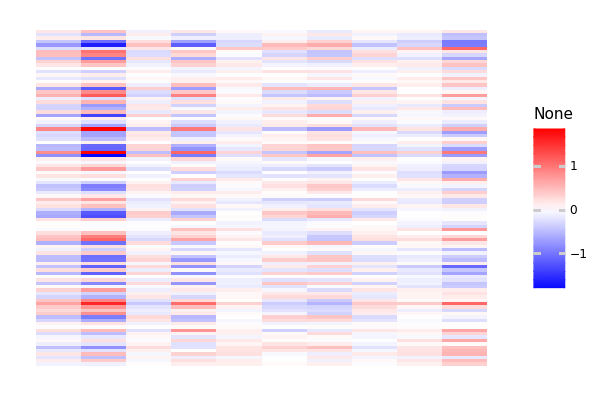

<ggplot: (8793315686193)>

In [3]:
lazytools.matrix_heatmap(dataset, pole=0)

## The minimal model

As a first step, we add tiers of specified shape, in this case a ten-dimensional input layer and a four-dimensional latent layer.

In [4]:
hpc_minimal = pc.Hierarchical()
hpc_minimal.add_tier(shape=(10, ))
hpc_minimal.add_tier(shape=(4, ))

Active connection: tier_1 -> tier_0


We can inspect the current result using the summary:

In [5]:
hpc_minimal.summary()

# Tier 1: tier_1

# Connection: tier_1 -> tier_0
(No tier connection defined.)

# Tier 0: tier_0


The 'connection' property refers to the currently activated connection, in this case the connection between tier 1 and tier 0.

This connection specifies how tier 1 is inferred from tier 0 with the observed data. The class `pc.TopDownPrediction()` provides a classical hierarchical predictive connection where tier 1 is used to predict tier 0 and the values of tier 1 are inferred to optimize this prediction. The provided model must be a Keras model that specifies how tier 0 is predicted from tier 1. Specifically, `pc.TopDownSequential` instantiates a [Sequential](https://keras.io/getting-started/sequential-model-guide/) model.

For example, a simple linear connection is given by a sequential model consisting of single dense linear connection.

In [6]:
import tensorflow.keras as keras
hpc_minimal.connection = pc.connections.TopDownSequential()
hpc_minimal.connection.add(keras.layers.Dense(10, input_shape=(4, )))

The model is now ready to be compiled:

In [7]:
hpc_minimal.summary()

# Tier 1: tier_1

# Connection: tier_1 -> tier_0
Top-down prediction.
## Predictive model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
## Prediction error
## Loss function
<function mean_squared_error at 0x7f7791d54440>

# Tier 0: tier_0


By default, the prediction error is given by the difference between the prediction from tier 1 and the true values of tier 0, and the loss function is given by the mean squared error between the two. By compiling the model, we now specify how the states and the predictor weights are estimated.

In [8]:
hpc_minimal.compile(optimizer='adam')

We can now use `dataset` to train the model:

In [9]:
hpc_minimal.train(dataset)

We can now inspect the estimated tiers, predictions, and prediction errors:

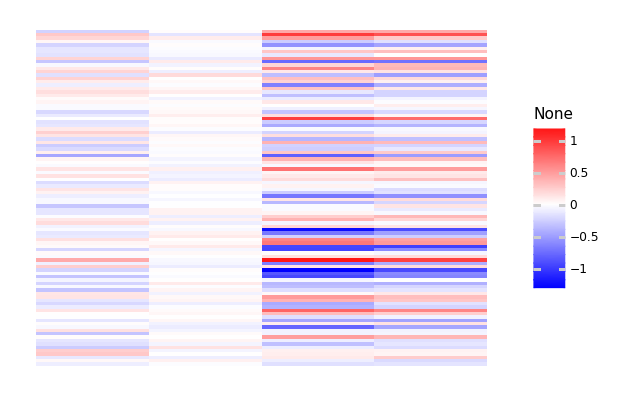

<ggplot: (8759428988677)>

In [10]:
lazytools.matrix_heatmap(hpc_minimal.tier(1).numpy(), pole=0)

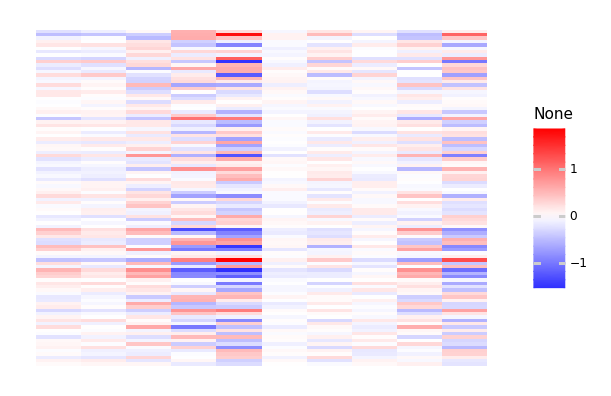

<ggplot: (8759457976277)>

In [11]:
lazytools.matrix_heatmap(hpc_minimal.prediction(0).numpy(), pole=0)

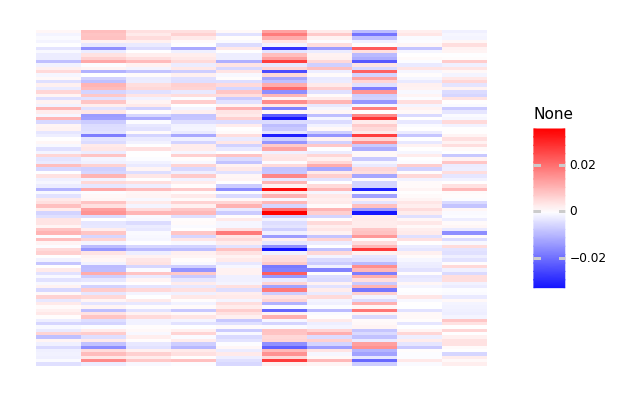

<ggplot: (8759434997257)>

In [12]:
lazytools.matrix_heatmap(hpc_minimal.prediction_error(0).numpy(), pole=0)

We can also inspect the estimated weights:

In [22]:
hpc_minimal.connection.model.get_weights()

[array([[ 0.2532234 , -0.23359032, -0.30848673, -0.46207476,  1.1907623 ,
          0.07036471,  0.0395364 , -0.5975455 , -0.0981449 ,  1.0263233 ],
        [ 0.96219337,  0.2996751 ,  0.4978161 ,  1.9671642 , -1.9097153 ,
         -0.6868669 , -0.89565444,  0.10537559, -0.8306558 , -0.6066443 ],
        [-0.54445493,  0.48863244, -2.0511308 ,  1.1066118 ,  0.02765923,
          0.75716937, -0.5193538 ,  0.6918637 , -0.7989001 ,  0.0691084 ],
        [ 0.13765734, -0.91446394,  2.0700321 , -0.11800873,  1.2984294 ,
         -0.8754481 ,  0.99491   , -0.85192275,  0.25543442,  0.7894489 ]],
       dtype=float32),
 array([ 3.7189270e-04, -6.3599268e-04,  1.6035611e-03, -6.4577075e-04,
         3.0221774e-03, -8.8079792e-04,  7.6713826e-04, -8.5571592e-05,
         6.6558714e-04,  3.4619228e-04], dtype=float32)]

## Optimization regimens

Hierarchical predictive coding must infer the latent variables and the predictor's weights. When both are taken together, the system is oversaturated. These variables must therefore be estimated in separate stages. Usually, this is solved by the Expectation-Maximization-Algorithm, iteratively estimating states and predictor variables until convergence. This means that the usual routine of simply specifying epochs is not sufficient. Instead, convergence criteria must be specified when estimation mode should be switched.

## Multiple tiers

Specifying multiple tiers works in exactly the same way:

In [20]:
hpc_three = pc.Hierarchical()
hpc_three.add_tier(shape=(10, ))
hpc_three.add_tier(shape=(4, ))
hpc_three.add_tier(shape=(2, ))

Active connection: tier_1 -> tier_0
Active connection: tier_2 -> tier_1


At the moment the active connection is given by the one between tier_2 and tier_1. We specify a sequential model with an intermediate nonlinearity.

In [21]:
import tensorflow.keras as keras
hpc_three.connection = pc.connections.TopDownSequential(
    layers=[
        keras.layers.Dense(4, input_shape=(2, )),
        keras.layers.Activation('relu'),
        keras.layers.Dense(4)
    ]
)

We now activate the connection between tier_1 and tier_0 to specify a linear model there.

In [22]:
hpc_three.activate_connection('tier_1')

Active connection: tier_1 -> tier_0


In [23]:
hpc_three.connection = pc.connections.TopDownSequential(
    layers=[keras.layers.Dense(10, input_shape=(4, ), use_bias=False)]
)

In [24]:
hpc_three.summary()

# Tier 2: tier_2

# Connection: tier_2 -> tier_1
Top-down prediction.
## Predictive model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
## Prediction error
## Loss function
<function mean_squared_error at 0x7ff5b65774d0>

# Tier 1: tier_1

# Connection: tier_1 -> tier_0
Top-down prediction.
## Predictive model
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Outpu

In [25]:
hpc_three.compile(optimizer=pc.regimens.OptimizerRegimen(
    keras.optimizers.Adam(),
    eps=1e-5
))

In [26]:
hpc_three.train(dataset)

We can now again examine this model:

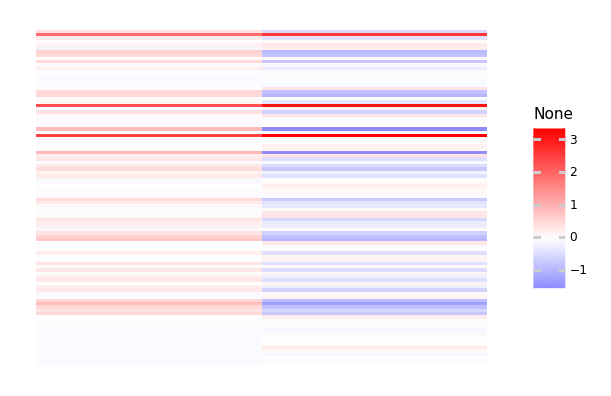

<ggplot: (8793270735457)>

In [27]:
lazytools.matrix_heatmap(hpc_three.tier(2).numpy(), pole=0)

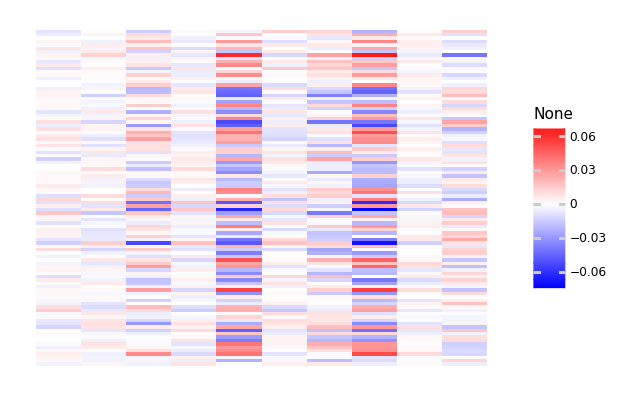

<ggplot: (8793161231269)>

In [37]:
lazytools.matrix_heatmap(hpc_three.prediction_error(0).numpy(), pole=0)

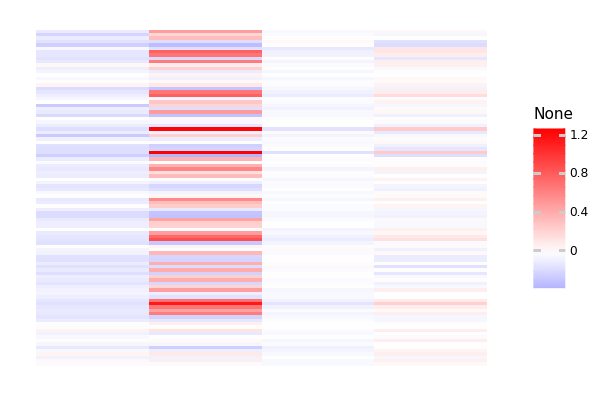

<ggplot: (8793152235493)>

In [39]:
lazytools.matrix_heatmap(hpc_three.prediction(1).numpy(), pole=0)

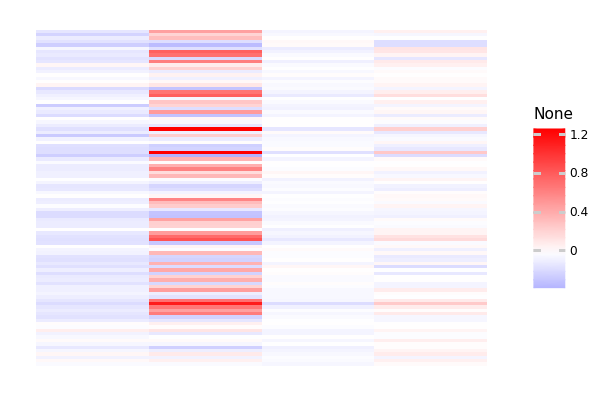

<ggplot: (8793162917905)>

In [40]:
lazytools.matrix_heatmap(hpc_three.tier(1).numpy(), pole=0)